<a href="https://colab.research.google.com/github/Alonment/CSCI4962-Projects-In-ML-AI/blob/main/CSCI4962_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Homework 5**

**CNNs, AEs, GANs**

In your project, you will pick an image dataset to solve a classification task. Provide a link to your dataset.

Problem: Classifying pokemon by type. (Since it is a childhood classic after all.)

Data set: https://www.kaggle.com/vishalsubbiah/pokemon-images-and-types?select=pokemon.csv

**Task 1 (70 points):**

**Part 1 (20 points):** This step involves downloading, preparing, and visualizing your dataset. Create a convulutional base using a common pattern: a stack of Conv and MaxPooling layers. Depending on the problem and the dataset you must decide what pattern you want to use (i.e., how many Conv layers and how many pooling layers). Please describe why you chose a particular pattern. Add the final dense layer(s). Compile and train the model. Report the final evaluation and describe the metrics.

**Part 2 (25 points):** The following models are widely used for transfer learning because of their performance and architectural innovations:


1.   VGG (e.g., VGG16 or VGG19).
2.   GoogleNet (e.g., InceptionV3).
3.   Residual Network (e.g., ResNet50).
4.   MobileNet (e.g., MobileNetV2).

Choose any **one** of the above models to perform the classification task in Part 1. Evaluate the results using the same metrics as in Part 1. Are there any differences? Why or why not?

**Part 3 (25 points):** Use data augmentation to increase the diversity of your dataset by applying random transformations such as image rotation (you can use any other technique as well). Repeat the process from part 1 with this augmented data. Did you observe any difference in results?



**Part 1:** The Convulutional Neural Network

In [231]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

BATCH_SIZE = 32
IMG_SIZE = (256, 256)
DRIVE_PATH = "drive/MyDrive/csci4962_hw5/"
# Loading our dataset
df = pd.read_csv(f"{DRIVE_PATH}pokemon.csv", encoding="UTF-8")


**Exploratory Data Analysis**

In [232]:
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [233]:
df.shape

(809, 3)

Let's drop the Type2 column due to the fact that they don't necessarily exist nor are they the main type of the pokemon; it also serves no purpose in classification based on type.

In [234]:
df = df.drop("Type2", axis=1).rename({"Type1": "Type"}, axis=1).sort_values("Name")
df.head()

,Name,Type
459,abomasnow,Grass
62,abra,Psychic
358,absol,Dark
616,accelgor,Bug
680,aegislash-blade,Steel


In [235]:
df.value_counts("Type")

Type
Water       114
Normal      105
Grass        78
Bug          72
Psychic      53
Fire         53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Dragon       27
Ghost        27
Steel        26
Ice          23
Fairy        18
Flying        3
dtype: int64

Seeing how the potential imbalance with these classes could bring about unwanted noise, let's reduce the problem to classifying pokemon into one of 4 categories: Water, Normal, Grass, or Bug type.

In [236]:
classes = ["Water", "Normal", "Grass", "Bug"]
df = df[df["Type"].isin(classes)]
df.value_counts("Type")

Type
Water     114
Normal    105
Grass      78
Bug        72
dtype: int64

Now, let us connect the images from the directory with the pokemon that we have left.

In [237]:
from pathlib import Path

# Retrieve the list of filenames from the directory and store each pokemon type in their respective folders
files = list(Path(DRIVE_PATH + 'images/images').glob("*"))
file_to_name = {file.name[:-4]: file for file in files}


In [238]:
!mkdir -p pokemon

In [239]:
import os
import shutil

# Resorted to making new directories because of difficulties creating an image dataset
for c in classes:
  dir = f'./pokemon/{c}'
  os.makedirs(dir, exist_ok=True)
  files = [file_to_name[name] for name in df[df['Type'] == c]['Name']]

  for file in files:
    output = Path(f'{dir}/{file.name}')
    shutil.move(file, output)


KeyError: ignored

It's about time we checked out the data we're working with. Let's begin generating our training, validation, and test sets as well as view the first 16 pokemon in our training set.

In [240]:
dataPath = Path('/content/pokemon')

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataPath,
    validation_split=0.25,
    label_mode='categorical',
    class_names=classes,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=0,
    subset="training"
  )

Found 369 files belonging to 4 classes.
Using 277 files for training.


In [241]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataPath,
    validation_split=0.2,
    label_mode='categorical',
    class_names=classes,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=0,
    subset="validation"
  )

test_ds = val_ds.take(1)
val_ds = val_ds.skip(1)

Found 369 files belonging to 4 classes.
Using 73 files for validation.


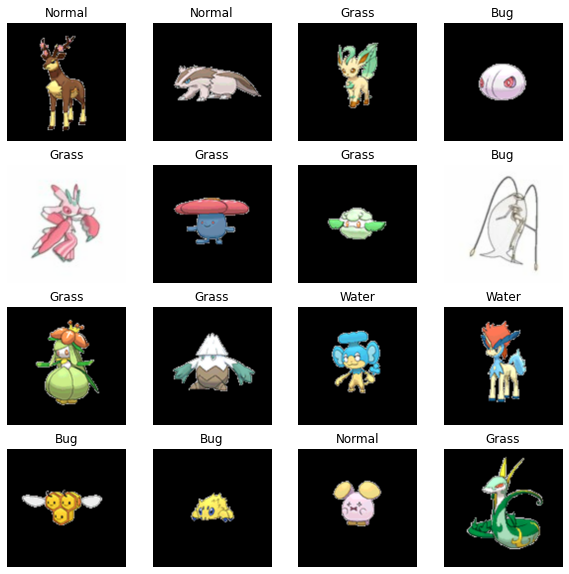

In [242]:
# Display images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[np.argmax(labels[i])])
    plt.axis("off")

By the look's of it, there is a lot of variation in pokemon of different type as well as on shape. However, it's clear that pokemon of the same type tend to follow the same color pattern, that being, water pokemon typically having the color blue, normal pokemon having colors not necesarilly associated with any element, and grass types having some form of green. Granted, these color patterns aren't exact/pokemon need not follow them (as is the case with the green fish that's a water type). Furthermore, there also appears to be some physical similarities between pokemon of certain types (i.e. water pokemon looking fishlike, bug pokemon looking like bugs..).

Now, it is time to create our test set and our model.



In [243]:
model = tf.keras.Sequential([
                             
  # Preprocessing Input layer
  tf.keras.layers.Resizing(256, 256, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
  
  # Convulutional and Pooling Layers
  tf.keras.layers.Conv2D(filters = 64, kernel_size = (7, 7), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters = 128, kernel_size = (7, 7), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters = 256, kernel_size = (7, 7), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  # Final Dense Layers
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4)
])

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_24 (Resizing)       (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_301 (Conv2D)          (None, 250, 250, 64)      9472      
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 125, 125, 64)      0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_302 (Conv2D)          (None, 119, 119, 128)     401536    
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 59, 59, 128)       0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 59, 59, 128)     

In [244]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [255]:
EPOCHS=8
history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=20
          )

Epoch 1/20
9/9 [==============================] - 5s 500ms/step - loss: 0.4431 - accuracy: 0.8267 - val_loss: 1.9989 - val_accuracy: 0.3902
Epoch 2/20
9/9 [==============================] - 5s 502ms/step - loss: 0.3612 - accuracy: 0.8448 - val_loss: 2.1584 - val_accuracy: 0.2927
Epoch 3/20
9/9 [==============================] - 5s 497ms/step - loss: 0.2865 - accuracy: 0.8809 - val_loss: 2.5631 - val_accuracy: 0.3902
Epoch 4/20
9/9 [==============================] - 5s 501ms/step - loss: 0.2377 - accuracy: 0.9025 - val_loss: 3.3261 - val_accuracy: 0.3171
Epoch 5/20
9/9 [==============================] - 5s 501ms/step - loss: 0.2042 - accuracy: 0.9134 - val_loss: 3.4667 - val_accuracy: 0.1707
Epoch 6/20
9/9 [==============================] - 5s 500ms/step - loss: 0.2693 - accuracy: 0.8736 - val_loss: 3.0529 - val_accuracy: 0.2927
Epoch 7/20
9/9 [==============================] - 5s 501ms/step - loss: 0.2101 - accuracy: 0.9061 - val_loss: 3.1649 - val_accuracy: 0.3902
Epoch 8/20
9/9 [====

In [262]:
loss, accuracy = model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Test accuracy: {accuracy}')

1/1 [==============================] - 0s 237ms/step - loss: 6.1842 - accuracy: 0.2500
Loss: 6.1842041015625
Test accuracy: 0.25


The CNN architecture is composed of 3 convulutuional and pooling layers respectively, with each pair being followed by a dropout layer in an attempt to reduce overfitting, which clearly did not work. At each conv layer, I doubled the number of filters while keeping them the same default size of (3 x 3) since the images themselves are relatively small. The results are somewhat astonishing, considering the model's high training accuracy and incredibly low validation accuracy in comparison. With a rather extreme case of overfitting, a possible explanation could be the sheer lack of sufficient training data, especially considering the fact that every image is itself a new and unique pokemon. Even despite reducing our class size to 4, the model can't seem to generalize well outside of the training set as both the validation and test set accuracies are poor.

**Part 2** GoogleNet( InceptionV3 )

In [247]:
inception = tf.keras.applications.inception_v3.InceptionV3(
  include_top=False,
  input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
  weights='imagenet'
)

In [248]:
# Building the model

input = tf.keras.Input((IMG_SIZE[0], IMG_SIZE[1], 3))
x = tf.keras.applications.inception_v3.preprocess_input(input)
x = inception(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(4)(x)
inception_model = tf.keras.Model(input, output)

inception_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

inception_model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_25 (TFOpLamb (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract_24 (TFOpLam (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_123 (Dense)            (None, 4)                 819

In [249]:
history = inception_model.fit(train_ds,
                    epochs=15,
                    validation_data=val_ds)

Epoch 1/15
9/9 [==============================] - 17s 962ms/step - loss: 1.3971 - accuracy: 0.4079 - val_loss: 31.3181 - val_accuracy: 0.3659
Epoch 2/15
9/9 [==============================] - 7s 774ms/step - loss: 0.8253 - accuracy: 0.6823 - val_loss: 44.4429 - val_accuracy: 0.1951
Epoch 3/15
9/9 [==============================] - 7s 776ms/step - loss: 0.4987 - accuracy: 0.8195 - val_loss: 146.9242 - val_accuracy: 0.1951
Epoch 4/15
9/9 [==============================] - 7s 773ms/step - loss: 0.4229 - accuracy: 0.8628 - val_loss: 79.9146 - val_accuracy: 0.2195
Epoch 5/15
9/9 [==============================] - 7s 774ms/step - loss: 0.3548 - accuracy: 0.8845 - val_loss: 8.1145 - val_accuracy: 0.1951
Epoch 6/15
9/9 [==============================] - 7s 774ms/step - loss: 0.2224 - accuracy: 0.9170 - val_loss: 6.5691 - val_accuracy: 0.2439
Epoch 7/15
9/9 [==============================] - 7s 780ms/step - loss: 0.1457 - accuracy: 0.9531 - val_loss: 12.0843 - val_accuracy: 0.1707
Epoch 8/15
9/

In [261]:
loss, accuracy = inception_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Test accuracy: {accuracy}')

1/1 [==============================] - 0s 303ms/step - loss: 12.1144 - accuracy: 0.4062
Loss: 12.11439037322998
Test accuracy: 0.40625


The pretrained InceptionV3 model seems to provide somewhat better, if not significantly better, results in comparison to the model I implemented in Part I. The overall training accuracy increased to a much higher value, along with the ultimate test accuracy being much higher as well as the validation-accuracy approaching a more stable, higher value relative to the model that I implemented.

**Part III** Data Augmentation

Tensorflow provides a handy suit of layers for Data augmentation as specified on https://www.tensorflow.org/tutorials/images/data_augmentation.

We can simply add some of these layers into our original model (to benefit from GPU accel) and see what effects it has. 

In [251]:
aug_model = tf.keras.Sequential([
                             
  # Preprocessing Input layer
  tf.keras.layers.Resizing(256, 256, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
  
  # Data Augmentation 
  tf.keras.layers.RandomRotation(0.05),
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomTranslation(0.98, 0.98),

  # Convulutional and Pooling Layers
  tf.keras.layers.Conv2D(filters = 64, kernel_size = (7, 7), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters = 128, kernel_size = (7, 7), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters = 256, kernel_size = (7, 7), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  # Final Dense Layers
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4)
])

aug_model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_25 (Resizing)       (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_3 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_398 (Conv2D)          (None, 250, 250, 64)      9472      
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 125, 125, 64)      0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 125, 125, 64)    

In [252]:
aug_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']  
)

In [253]:
history = aug_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=20
          )

Epoch 1/20
9/9 [==============================] - 6s 537ms/step - loss: 128.7313 - acc: 0.2383 - val_loss: 1.3890 - val_acc: 0.2439
Epoch 2/20
9/9 [==============================] - 5s 508ms/step - loss: 1.3846 - acc: 0.3032 - val_loss: 1.3726 - val_acc: 0.2195
Epoch 3/20
9/9 [==============================] - 5s 507ms/step - loss: 1.3748 - acc: 0.2527 - val_loss: 1.3388 - val_acc: 0.3171
Epoch 4/20
9/9 [==============================] - 5s 506ms/step - loss: 1.3764 - acc: 0.2816 - val_loss: 1.3448 - val_acc: 0.3659
Epoch 5/20
9/9 [==============================] - 5s 504ms/step - loss: 1.3797 - acc: 0.2744 - val_loss: 1.3652 - val_acc: 0.4878
Epoch 6/20
9/9 [==============================] - 5s 506ms/step - loss: 1.3767 - acc: 0.3032 - val_loss: 1.3710 - val_acc: 0.2927
Epoch 7/20
9/9 [==============================] - 5s 505ms/step - loss: 1.3725 - acc: 0.3069 - val_loss: 1.3585 - val_acc: 0.3902
Epoch 8/20
9/9 [==============================] - 5s 506ms/step - loss: 1.3773 - acc: 0.

In [254]:
loss, accuracy = aug_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Test accuracy: {accuracy}')

1/1 [==============================] - 0s 227ms/step - loss: 1.3700 - acc: 0.3125
Loss: 1.3700456619262695
Test accuracy: 0.3125


Perhaps too much data augmentation was used, since the training accuracy is **significantly** lower than that without. However, despite that, the validation accuracy and test accuracy still remain at decent values with respect to our original model. Given this, the training accuracy does seem to better approximate the test/validation accuracy and a case could be made that overfitting was reduced greatly, despite the accuracy itself being rather poor.

**Task 2 (30 points):**


**Part 1 (15 points)**: Variational Autoencoder(VAE): Here is a complete implementation of a VAE in TensorFlow: https://www.tensorflow.org/tutorials/generative/cvae

Following these steps try generating images using the same encoder-decoder architecture using a different image dataset (other than MNIST).

**Part 2 (15 points)**: Generative Adversarial Networks (GAN): Repeat part 1 (use same dataset) and implement a GAN model to generate high quality syntheitc images. You may follow steps outlined here: : https://www.tensorflow.org/tutorials/generative/dcgan

**Part 1** 

Let's begin by using the code they provide in their tutorial.

In [266]:
def preprocess_images(images):
  images = images / 255. # Our images are already sized properly
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = np.concatenate([image for image, _ in train_ds], axis=0)
test_images = np.concatenate([image for image, _ in val_ds], axis=0)

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)



In [267]:
train_size = 60000
batch_size = 32
test_size = 10000

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

All of the following sgements will simply be taken from the tutorial code since its already provided and altered accordingly to work with our pokemon dataset.

In [423]:
# Directly from the tensorflow tutorial
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=64**3, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(64, 64, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [424]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [425]:
epochs = 30
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [426]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [427]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 30, Test set ELBO: -46882.15625, time elapse for current epoch: 2.2847046852111816


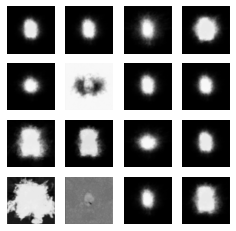

In [428]:
import time
from IPython import display 

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

Well, those are some of the most interesting pokemon I've ever seen.

**Part 2:** DCGAN

Similar to the first part, let us simply use the provided code, fiddling around where necessary in order to accomadate our pokemon images.

In [431]:
train_images = np.concatenate([image for image, _ in train_ds], axis=0)
train_labels = np.concatenate([label for _, label in train_ds], axis=0)


train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [432]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [433]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [436]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

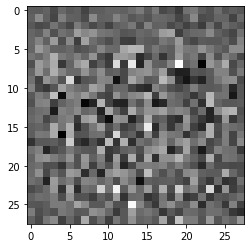

In [437]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [440]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [441]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00191755]], shape=(1, 1), dtype=float32)


In [442]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [443]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [444]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [445]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [446]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [447]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [448]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [449]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [450]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [451]:
train(train_dataset, EPOCHS)

ValueError: ignored

unfinished gan